In [2]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

In [4]:
def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

In [5]:
num_bits_per_symbol = 4
c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)

for i in range(0, 2**num_bits_per_symbol):
    b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),dtype=np.int16)
    print(b)
    c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension
    # print(c[i])

    # normalization
    n = int(num_bits_per_symbol/2)
    qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
    c /= np.sqrt(qam_var)

print(c)
c = tf.stack([tf.math.real(c), tf.math.imag(c)], axis=0)
print(c)

# _c = tf.Variable(c, trainable=True, dtype=tf.as_dtype(tf.complex64).real_dtype)
# print(_c)

# figsize=(7,7)
# maxval = np.max(np.abs(c))*1.05
# fig = plt.figure(figsize=figsize)
# ax = fig.add_subplot(111)
# plt.xlim(-maxval, maxval)
# plt.ylim(-maxval, maxval)
# plt.scatter(np.real(c), np.imag(c))
# ax.set_aspect("equal", adjustable="box")
# plt.grid(True, which="both", axis="both")
# plt.title("Constellation Plot")
# for j, p in enumerate(c):
#     plt.annotate(
#         np.binary_repr(j, num_bits_per_symbol),
#         (np.real(p), np.imag(p))
#     )

[0 0 0 0]
[0 0 0 1]
[0 0 1 0]
[0 0 1 1]
[0 1 0 0]
[0 1 0 1]
[0 1 1 0]
[0 1 1 1]
[1 0 0 0]
[1 0 0 1]
[1 0 1 0]
[1 0 1 1]
[1 1 0 0]
[1 1 0 1]
[1 1 1 0]
[1 1 1 1]
[ 9.99999994e-09+9.99999994e-09j  3.16227755e-08+9.48683123e-08j
  2.99999954e-07+9.99999941e-08j  9.48683180e-07+9.48683180e-07j
  9.99999997e-07-9.99999997e-07j  3.16227784e-06-9.48683191e-06j
  2.99999956e-05-1.00000007e-05j  9.48683155e-05-9.48683155e-05j
 -1.00000005e-04+1.00000005e-04j -3.16227786e-04+9.48683126e-04j
 -2.99999956e-03+1.00000005e-03j -9.48683172e-03+9.48683172e-03j
 -1.00000007e-02-1.00000007e-02j -3.16227786e-02-9.48683247e-02j
 -2.99999982e-01-1.00000001e-01j -9.48683262e-01-9.48683262e-01j]
tf.Tensor(
[[ 9.99999994e-09  3.16227755e-08  2.99999954e-07  9.48683180e-07
   9.99999997e-07  3.16227784e-06  2.99999956e-05  9.48683155e-05
  -1.00000005e-04 -3.16227786e-04 -2.99999956e-03 -9.48683172e-03
  -1.00000007e-02 -3.16227786e-02 -2.99999982e-01 -9.48683262e-01]
 [ 9.99999994e-09  9.48683123e-08  9.999999

tf.Tensor([1. 0. 1. ... 0. 1. 1.], shape=(8352,), dtype=float32)
c shape:  (64, 8352)
tf.Tensor(
[-0.9486833+0.9486833j  0.9486833+0.9486833j -0.3162278+0.9486833j ...
 -0.9486833-0.3162278j  0.9486833+0.9486833j -0.9486833+0.9486833j], shape=(2088,), dtype=complex64)
x shape:  (64, 2088)


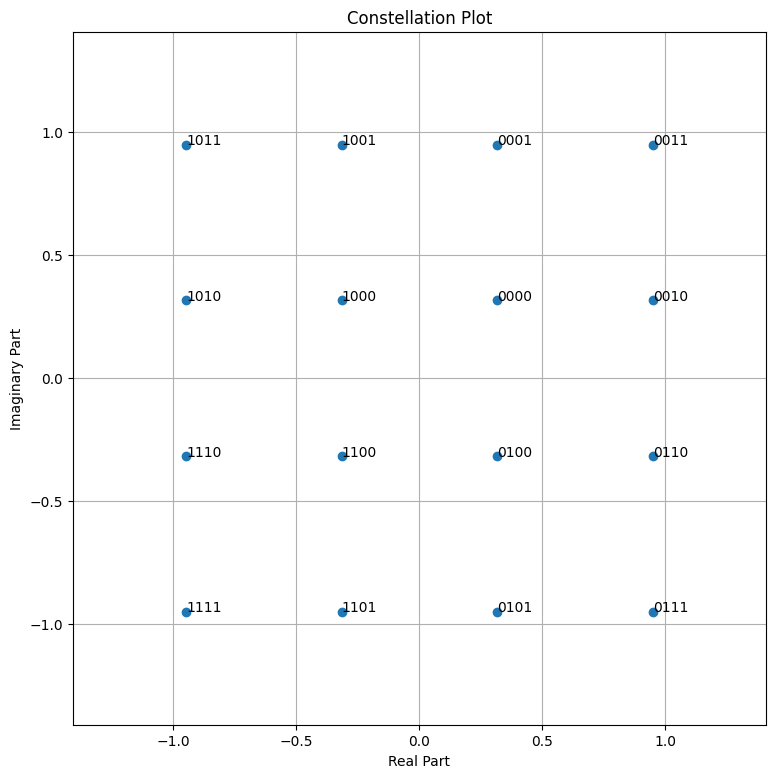

In [6]:
batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
coderate = 0.5
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
n = 8352

binary_source = BinarySource()

# trainable constellation
constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
# constellation.show()
figsize=(9,9)
maxval = np.max(np.abs(constellation.points))*1.05
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
plt.scatter(np.real(constellation.points), np.imag(constellation.points))
ax.set_aspect("equal", adjustable="box")
plt.grid(True, which="both", axis="both")
plt.title("Constellation Plot")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
for j, p in enumerate(constellation.points):
    plt.annotate(
        np.binary_repr(j, num_bits_per_symbol),
        (np.real(p), np.imag(p))
    )

mapper = Mapper(constellation=constellation)

## Transmitter
# Generate codewords
codeword = binary_source([batch_size, n])
print(codeword[0])
print("c shape: ", codeword.shape)
# Map bits to QAM symbols
x = mapper(codeword)
print(x[0])
print("x shape: ", x.shape)